<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/Regression/VineyardExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exploration notebook
  - load data
  - check data types of columns
  - check outliers
  - check missing values
  - plot distributions
  - calculate correlations between input features and target variable
  - calculate correlations between input features
  - normalize/standardize input dataset
  - calculate pca for feature reduction and achieve input feature independence

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

In [21]:
# set column names
columns = ['x0', 'x1', 'x2', 'x3', 'u']
features = ['x0', 'x1', 'x2', 'x3']
target = ['u']
# define ranges of all features
feature_ranges = {"x0": [1, 17], "x1": [-9, -4], "x2": [0, 3], "x3": [0, 50]}
# path to data source
source_path = "./Data/podaci.csv"
# split sizes for train, validation and test subsets
train_size, test_size, val_size = 0.8, 0.2, 0.2
# num of new samples
f_range = 100

In [22]:
df = pd.read_csv(source_path, names=columns)
df.head()

,x0,x1,x2,x3,u
0,9.353670,-5.681740,1.739091,26.117712,95.610349
1,7.136365,-8.842209,1.712237,42.389300,171.811854
2,11.457191,-8.771499,1.500788,41.984114,173.865403
3,8.772591,-4.087157,2.443511,12.612862,53.146681
4,4.958833,-8.140877,1.651389,34.904362,142.692822


In [23]:
df.describe()

,x0,x1,x2,x3,u
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,8.791439,-6.613959,1.528241,26.049980,108.149899
std,4.653434,1.412722,0.858456,13.886081,34.839117
min,1.253278,-8.994504,0.053720,0.049785,22.550903
25%,4.679236,-7.922337,0.758000,15.002370,81.192576
50%,8.724418,-6.601377,1.552406,26.236388,110.872981
75%,12.766403,-5.485084,2.291555,36.993059,136.567023
max,16.991696,-4.006333,2.989752,49.719666,185.125604


Sensor data are not out of range for all features.

In [24]:
df.dtypes

x0    float64
x1    float64
x2    float64
x3    float64
u     float64
dtype: object

In [25]:
df_missing = df.isnull().sum()
df_missing

x0    0
x1    0
x2    0
x3    0
u     0
dtype: int64

In [26]:
def miss_percentage(df):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :return:   pandas dataframe, index = column names, columns = [missing values percentage, missing count]
    """
    df_missing = df.isnull().sum().reset_index()
    df_missing.columns = ['features', 'missing_counts']
    df_len = df.shape[0]
    df_missing['missing_percentage'] = df_missing['missing_counts'].apply(lambda v: v/df_len)

    return df_missing.sort_values(by='missing_percentage', ascending=False).set_index(keys='features')

In [27]:
df_miss_info = miss_percentage(df)
df_miss_info

,missing_counts,missing_percentage
features,,
x0,0,0.0
x1,0,0.0
x2,0,0.0
x3,0,0.0
u,0,0.0


All features are numeric (float) and there is no missing values.

### Calculate feature correlations

In [28]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [29]:
def plot_feature_distributions(df):
  """
  Plot histograms of all featues.
  """

  fig, ax = plt.subplots(2, 2)
  sns.distplot(df['x0'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[0, 0])
  sns.distplot(df['x1'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[0, 1])
  sns.distplot(df['x2'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[1, 0])
  sns.distplot(df['x3'], hist=True, kde=False, label='All values', bins=20,
             ax=ax[1, 1])

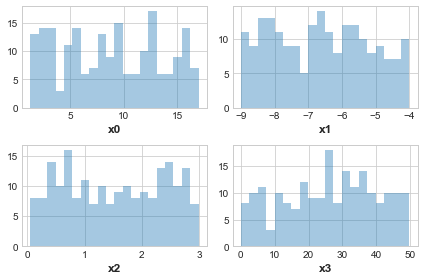

In [30]:
plot_feature_distributions(df)

All features need to be normalized with sifting distribution to become more like bell shape curve.

In [31]:
def plot_target_distribution():
  """
  Plot histograms of target variable.
  """

  sns.distplot(df['u'], hist=True, kde=False, label='All values', bins=40)

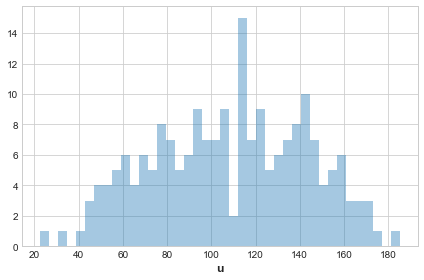

In [32]:
plot_target_distribution()

Target variable can be just standardized because distribution is approximately bell shape curve.

### Correlations between features and target variable

In [14]:
import scipy as sc

def get_correlation_coefficients(features_combinations: list):
  """
  Calculate Pearson and Spearman correlation coefficients between features
  and target variable.
  :param features_combinations: list of combinations of input features and target names, list of tuples
  :return result_coefficients: dict, key - name of related features, value - pandas dataframe
  """

  result_coefficients = {}

  for features in features_combinations:
    
      stats_pe_spe = {"corr": [], "p-value": []}

      pearson_price_points = sc.stats.pearsonr(df[features[0]], df[features[1]])
      spearman_price_points = sc.stats.spearmanr(df[features[0]], df[features[1]])

      for i in range(len(list(stats_pe_spe.keys()))):
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(pearson_price_points[i])
        stats_pe_spe[list(stats_pe_spe.keys())[i]].append(spearman_price_points[i])

      result_coefficients[features[0] + "-" + features[1]] = pd.DataFrame(stats_pe_spe, columns=['corr', 'p-value'], index=['pearson', 'spearman'])  
  
  return result_coefficients

In [15]:
r = 2
features_target = list(set(list(combinations(columns, r))))
result_coefficients = get_correlation_coefficients(features_target)


In [16]:
for feature in list(result_coefficients.keys()):
  print(feature)
  print("----------------------------")
  print(result_coefficients[feature])
  print("\n")

x0-x2
----------------------------
              corr   p-value
pearson  -0.031766  0.655207
spearman -0.018674  0.792969


x2-u
----------------------------
              corr   p-value
pearson  -0.002399  0.973100
spearman  0.003611  0.959531


x1-x2
----------------------------
              corr   p-value
pearson   0.006414  0.928178
spearman  0.005717  0.935967


x0-x1
----------------------------
              corr   p-value
pearson  -0.071891  0.311718
spearman -0.076520  0.281502


x1-u
----------------------------
              corr       p-value
pearson  -0.573213  7.299622e-19
spearman -0.563587  3.677339e-18


x1-x3
----------------------------
              corr   p-value
pearson  -0.040232  0.571643
spearman -0.043659  0.539315


x3-u
----------------------------
              corr       p-value
pearson   0.828818  7.960407e-52
spearman  0.833077  8.228812e-53


x2-x3
----------------------------
              corr   p-value
pearson  -0.034601  0.626679
spearman -0.024545

In [17]:
def plot_feature_correlations(df):
  """
  Draw scatter plots and histograms of all features.
  :param df: input pandas dataframe
  """
  sns.pairplot(df)


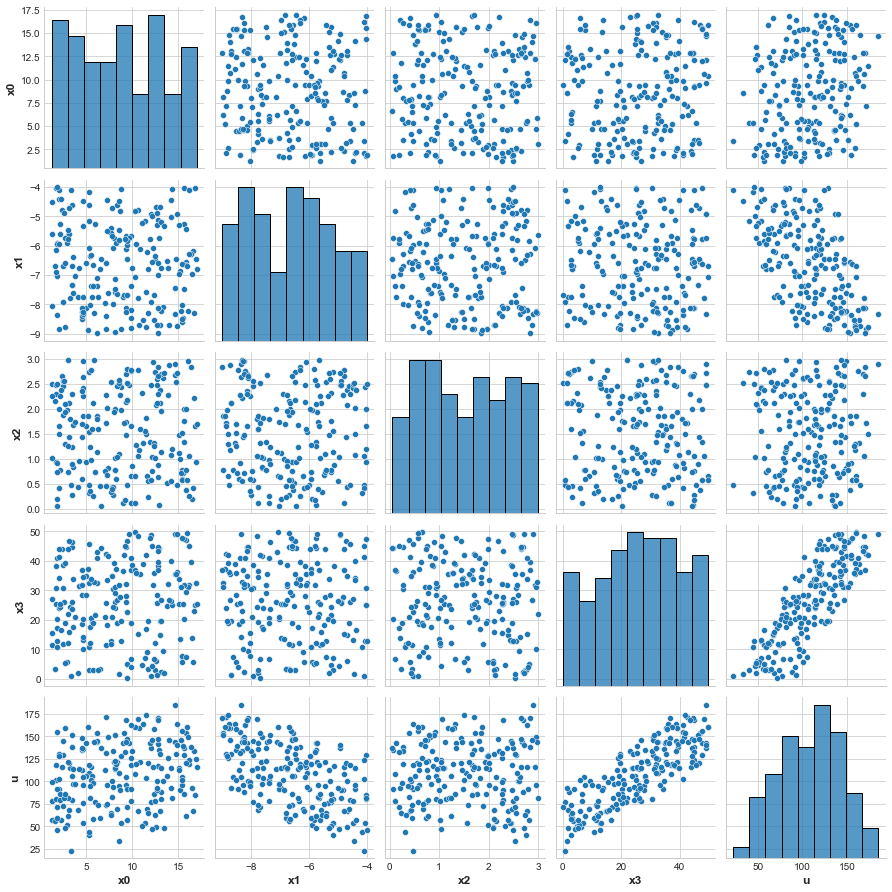

In [18]:
plot_feature_correlations(df)

x3 is feature of high relevance.
All input features are independent between each other.

### Prepare dataset

In [37]:
def split_data(df: pd.DataFrame, features: list, target: list, train_size: float, 
               test_size: float, val_size: float):
  """
  Split dataset on train, test and validation subsets.
  :param df:          input pandas DataFrame
  :param features:    list of input features names
  :param target:      list of target column names
  :param train_size:  fraction of train size
  :param test_size:   fraction of test size
  :param val_size:    fraction of validation size
  :return:            dictionary, keys=names of DataFrame, columns=DataFrame
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  x_train, x_test, y_train, y_test = train_test_split(df[features], df[target],
                                     test_size=test_size, train_size=train_size)
    
  # split train set on train and validation subsets
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                      test_size=val_size, train_size=train_size)
  
  dataset_dict = {
      'x_train': x_train,
      'y_train': y_train,
      'x_val': x_val,
      'y_val': y_val,
      'x_test': x_test,
      'y_test': y_test
  }

  return dataset_dict

In [38]:
dataset = split_data(df, features, target, train_size, test_size, val_size)

In [39]:
print("Train dataset shape: {}".format(dataset['x_train'].shape))
print("Validation dataset shape: {}".format(dataset['x_val'].shape))
print("Test dataset shape: {}".format(dataset['x_test'].shape))

Train dataset shape: (128, 4)
Validation dataset shape: (32, 4)
Test dataset shape: (40, 4)


In [40]:
def cause_relevant_features(df: pd.DataFrame, features: list, f_range: int):
  """
  Cause new data based on calculated statistics.
  :param df:          input pandas DataFrame
  :param f_range:     int, num of new samples
  :return new_df:     pandas DataFrame with new data
  """

  new_data = {}

  for idx in range(len(features)):

    std = df[features[idx]].std()
    mean = df[features[idx]].mean()

    data_range = [mean - (1.5 * std), mean + (1.5 * std)]

    new_data[features[idx]] = np.random.uniform(data_range[0], data_range[1], f_range).reshape(f_range, 1).tolist()

  new_df = pd.DataFrame.from_dict(new_data)
  
  for fidx in range(len(features)):
    new_df[features[fidx]] = new_df[features[fidx]].map(lambda x: x[0])

  return new_df

In [42]:
new_data = cause_relevant_features(dataset['x_train'], features, f_range)
new_data.describe()

,x0,x1,x2,x3
count,100.000000,100.000000,100.000000,100.000000
mean,7.912654,-6.471946,1.483057,29.384306
std,3.929035,1.198170,0.752537,11.362230
min,1.832156,-8.536378,0.234957,6.344897
25%,4.323668,-7.382997,0.955882,22.041106
50%,8.127013,-6.533579,1.463790,28.772253
75%,10.790018,-5.369755,2.138874,39.552635
max,15.938067,-4.536303,2.763835,46.819909


In [43]:
def get_target_values(df: pd.DataFrame, target: list):
  """
  Return values of target variable based on input feature values.
  :param df:               pandas dataframe with input features
  :return target_result:   pandas dataframe with input features and target values
  """
  
  def calc_target_func(x0, x1, x2, x3):
    """
    Return target value.
    """

    return x0 + (x1**2) + x2 + (2*x3)
  

  df[target[0]] = df.apply(lambda row: calc_target_func(row['x0'], row['x1'], row['x2'], row['x3']), axis=1)

  return df

In [44]:
new_data = get_target_values(new_data, target)
new_data.describe()

,x0,x1,x2,x3,u
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.912654,-6.471946,1.483057,29.384306,111.471667
std,3.929035,1.198170,0.752537,11.362230,28.581617
min,1.832156,-8.536378,0.234957,6.344897,46.394691
25%,4.323668,-7.382997,0.955882,22.041106,92.652136
50%,8.127013,-6.533579,1.463790,28.772253,108.719820
75%,10.790018,-5.369755,2.138874,39.552635,131.616286
max,15.938067,-4.536303,2.763835,46.819909,178.098612


Plot distributions and correlations between features and target variable in newly sampled dataset. 

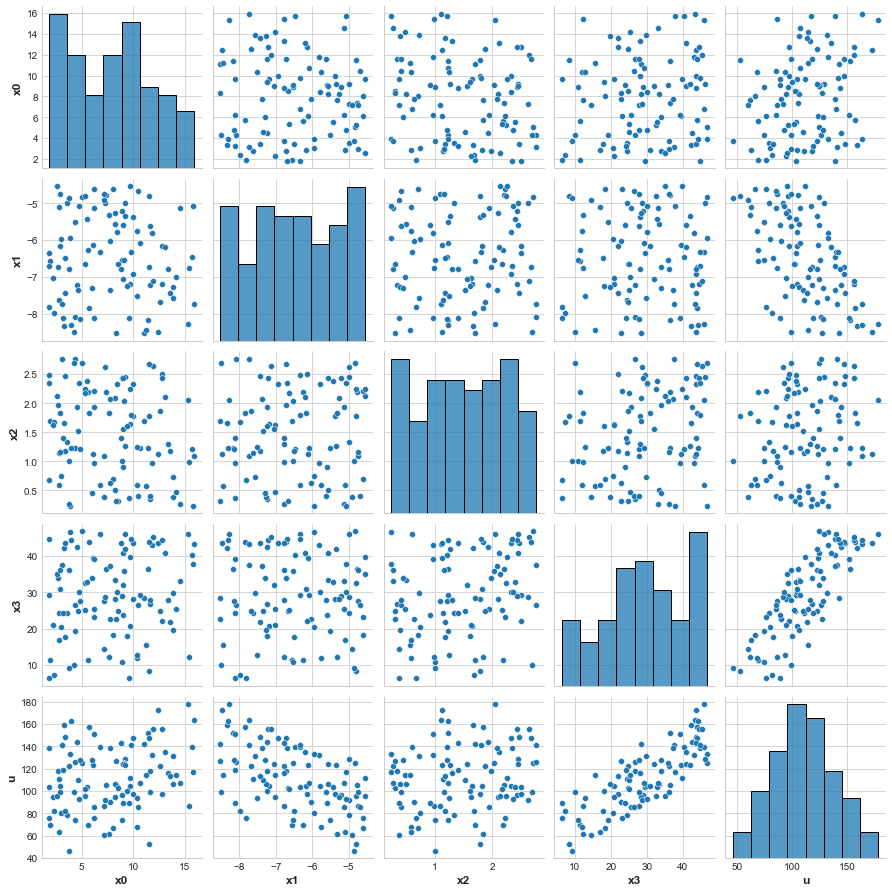

In [45]:
plot_feature_correlations(new_data)

In a new dataset features containes independent between each other while x3 feature is the most relevant in relation to target variable.

In [46]:
def create_extra_train_dataset(df: pd.DataFrame, df_new: pd.DataFrame):
  """
  Extend train dataset with new data.
  :param df:               pandas dataframe with input features
  :param df_new:           pandas dataframe with input augmented features
  :return df_result:       pandas dataframe with input features and target values
  """

  return pd.concat([df, df_new], axis=0).reset_index()[features + target]

### Normalize input datasets

In [48]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

def normalize_features(df: pd.DataFrame, features: list, target: list):
  """
  Use Yeo-Johnson transform to normalize input features and target variable.
  :param df:        dict with input pandas dataframes
  :param features:  list of input features names
  :param target:    list of target variables names
  :return out_data: dict, data = pandas dataframe with transformed data,
                          transformer = transformer objects
  """
  
  out_data = {'data': {}, 'transformers': []}
  transformers = []
  df_x = {}
  df_y = {}

  # normalize input data
  for key in list(df.keys()):

    if key == 'train_data':
      # fit input features
      transformer_f = PowerTransformer(method='yeo-johnson', standardize=True)
      x_trans = transformer_f.fit_transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)
      transformers.append(transformer_f)

      # fit input target
      transformer_t = PowerTransformer(method='yeo-johnson', standardize=True)
      y_trans = transformer_t.fit_transform(df[key][target])
      df_y[key] = pd.DataFrame(y_trans, columns=target)
      transformers.append(transformer_t)

    elif key == 'test_data':
      # transform input features
      x_trans = transformers[0].transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)

      # use test target variable
      y_trans = df[key][target]
      df_y[key] = pd.DataFrame(y_trans, columns=target)
    
    else:
      # transform input features
      x_trans = transformers[0].transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)

      # transform target variable
      y_trans = transformers[1].transform(df[key][target])
      df_y[key] = pd.DataFrame(y_trans, columns=target)

  # concatenate all transformed features dataframes with transformed target variables
  for key in list(df.keys()):
    out_data['data'][key] = pd.concat([df_x[key], df_y[key]], axis=1)
  
  out_data['transformers'] = transformers

  return out_data

In [55]:
# normalize train dataset
df_data = {}
train_data = pd.concat([dataset['x_train'], dataset['y_train']], axis=1)
df_data['train_data'] = train_data
norm_train = normalize_features(df_data, features, target)

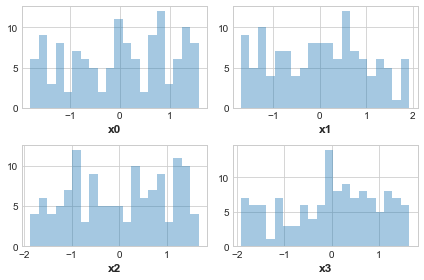

In [57]:
plot_feature_distributions(norm_train['data']["train_data"])

### PCA analysis
With pca analysis we will get independent principal components with explained variance ratio.

In [58]:
def pca(x):
  """
  Get new features by PCA analysis.
  :param x:                 pandas dataframe with input features
  :return train_pca, pca:   pandas dataframe with transformed data, PCA object
  """

  # Create principal components
  pca = PCA()
  x_pca = pca.fit_transform(x)

  # Convert to dataframe
  component_names = [f"PC{i+1}" for i in range(x_pca.shape[1])]
  train_pca = pd.DataFrame(x_pca, columns=component_names)

  return train_pca, pca

In [62]:
# pca analysis train dataset
train_pca, pca_train = pca(norm_train['data']["train_data"][['x0', 'x1', 'x2', 'x3']])


In [63]:
# Look at explained variance
print(pca_train.explained_variance_ratio_)

[0.2948625  0.25425981 0.23029085 0.22058684]


### Conclusion
Like me can see all the components contains near the same variance ratio in dataset. So we can't reduce number of features in input dataset. Because all input features before pca was also independent we will not use pca to transform input data.